In [203]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import solve_ivp, quad
from scipy.interpolate import CubicSpline
from simulation.finance_data import FinanceData

dat = FinanceData()
dat.download()

[*********************100%***********************]  1 of 1 completed

{0.08493150684931507: 0.008539042758088922, 0.16164383561643836: 0.024254986404143253, 0.2465753424657534: -0.02688714062127162, 0.3287671232876712: 0.09198919079889456, 0.4136986301369863: -0.008886365681221697}


In [250]:
def lambda_(t):
    return 0.2#.15 #10% annuo

def mu(t):
    return 0.20 #5% annuo


def rr(t):
    return dat.market_rr(t) * 12
    #return 0.05

def rp(t):
    return 0.1
    #return 0.1 #10% annnuo

intervals = 1000
# Supponiamo che t sia espresso in mesi

av_k = 5

def pde_system(t, y):
    i, p, d = y

    lambda__ = lambda_(t)
    mu_ = mu(t)
    di_dt = lambda__ * p * av_k * i - mu_ * i
    dp_dt = -lambda__ * p * av_k * i
    dd_dt = mu_ * i

    return [di_dt, dp_dt, dd_dt]

t_span = (0., 30.)

sol = solve_ivp(pde_system, t_span, [0.001, 1, 0], t_eval=np.linspace(0, 30, intervals))
t = sol.t
i_val = sol.y[0]
p_val = sol.y[1]
d_val = sol.y[2]

i = CubicSpline(t, i_val)
p = CubicSpline(t, p_val)
d = CubicSpline(t, d_val)

def g(tau, t):
    return 100*np.exp(quad(rp, tau, t)[0])


N = 1000

def joined_at_time(tau):
    return lambda_(tau) * av_k * p(tau) * i(tau)

def joined_at_time_and_hasnt_left(tau, t):
    return joined_at_time(tau) * np.exp(- quad(lambda ti: mu(ti), tau, t)[0])

def W(t):
    if t == 0: return 0
    else:
        return (N * mu(t) * i(t) * quad(lambda tau: joined_at_time_and_hasnt_left(tau, t) * 100 * np.exp(rp(t) * (t-tau)) , 0, t)[0]) / quad(lambda tau: joined_at_time_and_hasnt_left(tau, t), 0, t)[0]
            #/ quad(lambda tau: joined_at_time(tau), 0, t)[0])

def av_W(t):
    return W(t) / (N * mu(t) * i(t))


In [251]:
def S_der(t, S):
    #print('at time ', t, 'we have', W(t))
    return rr(t) * max(S, 0) +  N * 100 * joined_at_time(t) - W(t)#100 * N * lambda_(t) * p(t) * i(t) * av_k - W(t)#S * rr(t) +  100 * N * lambda_(t) * p(t) * av_k * i(t) #-  W(t)
    #return 100 * N * lambda_(t) * p(t) * av_k * i(t) -  W(t)

sol_S = solve_ivp(S_der, t_span, [100], t_eval=np.linspace(0, 30, intervals))
S_values = sol_S.y[0]
t = sol_S.t

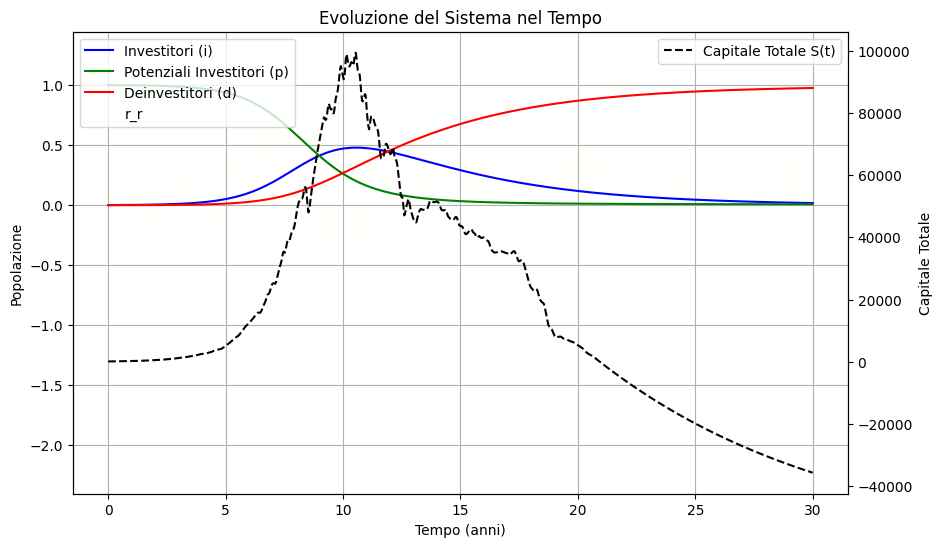

In [254]:
fig, ax1 = plt.subplots(figsize=(10, 6))

# Primo asse y
ax1.plot(t, i(t), label='Investitori (i)', color='blue')
ax1.plot(t, p(t), label='Potenziali Investitori (p)', color='green')
ax1.plot(t, d(t), label='Deinvestitori (d)', color='red')
ax1.plot(t, [rr(ti) for ti in t], label='r_r', color='yellow', alpha=0.01)
ax1.set_xlabel('Tempo (anni)')
ax1.set_ylabel('Popolazione')
ax1.legend(loc='upper left')
ax1.grid()

# Secondo asse y per S(t)
ax2 = ax1.twinx()
ax2.plot(t, S_values, label='Capitale Totale S(t)', color='black', linestyle='dashed')
ax2.set_ylabel('Capitale Totale')
ax2.legend(loc='upper right')

plt.title('Evoluzione del Sistema nel Tempo')
plt.show()


C:\Users\Torto\AppData\Local\Temp\ipykernel_2656\2953190865.py:2: IntegrationWarning: The maximum number of subdivisions (5) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  plt.plot(t_values, [quad(lambda tau: W(tau), 0, ti, limit=5)[0] for ti in t_values])


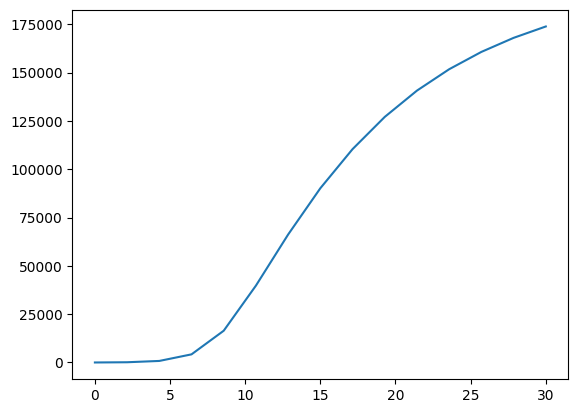

In [249]:
t_values = np.linspace(0, 30, 15)
plt.plot(t_values, [quad(lambda tau: W(tau), 0, ti, limit=5)[0] for ti in t_values])

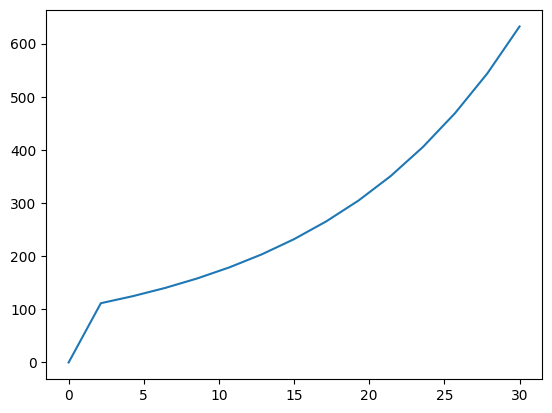

In [229]:
plt.plot(t_values, [av_W(ti) for ti in t_values])


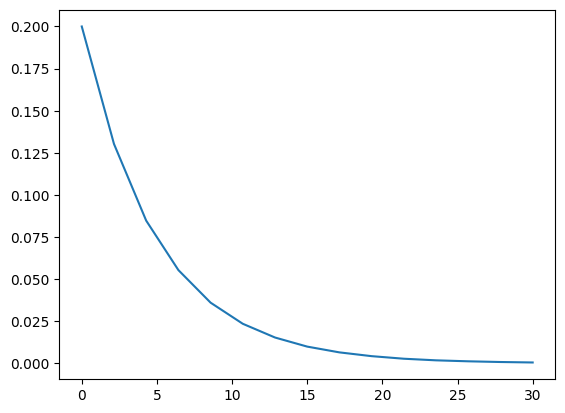

In [230]:
plt.plot(t_values, [(N * mu(t) * i(t)) for t in t_values])

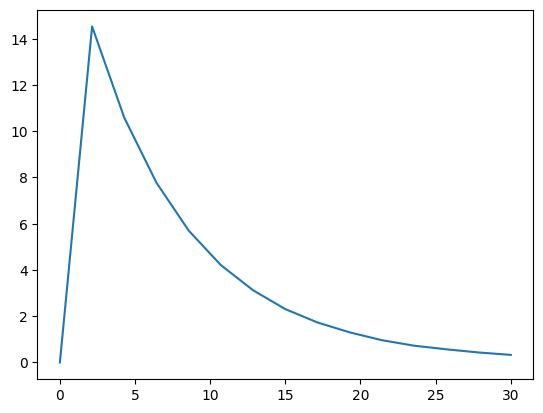

In [231]:
plt.plot(t_values, [av_W(t) * N * mu(t) * i(t) for t in t_values])

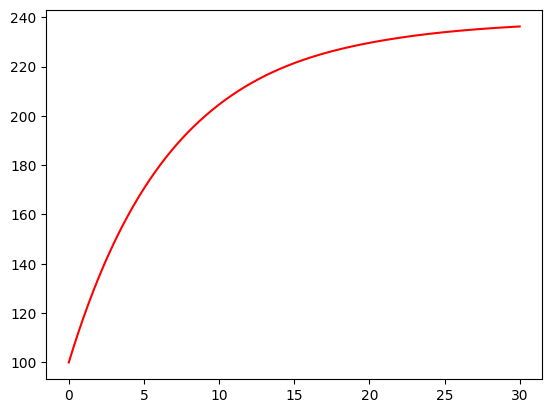

In [232]:
def money_lost_der(t, lost):
    return W(t)
sol_lost = solve_ivp(money_lost_der, t_span, [100], t_eval=np.linspace(0, 30, intervals))
t = sol_lost.t
plt.plot(t, sol_lost.y[0], label='money lost', color='red')

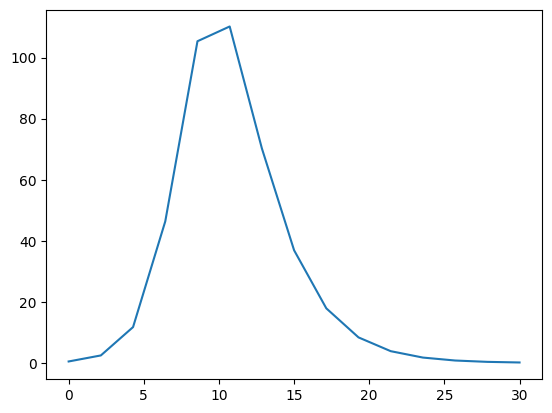

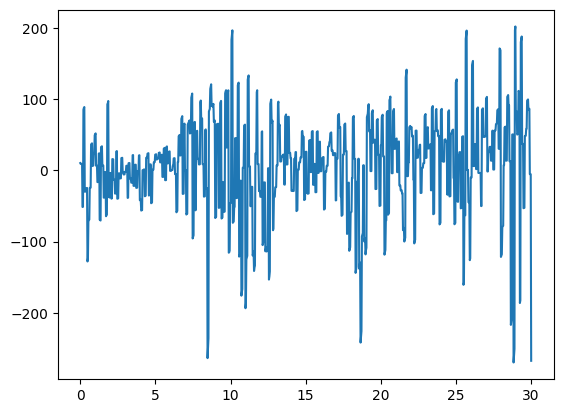

In [233]:
plt.plot(t,[S_der(t[i], S_values[i]) for i in range(len(t))])

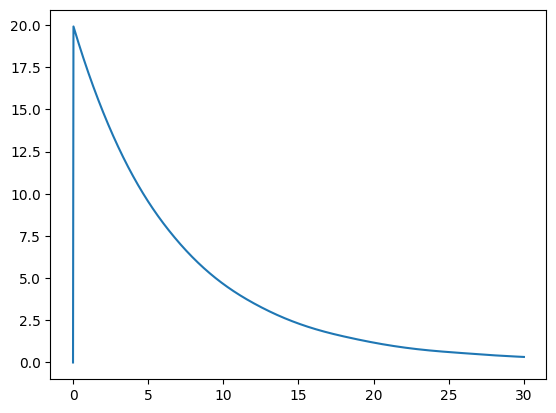

In [234]:
plt.plot(t, [W(ti) for ti in t])

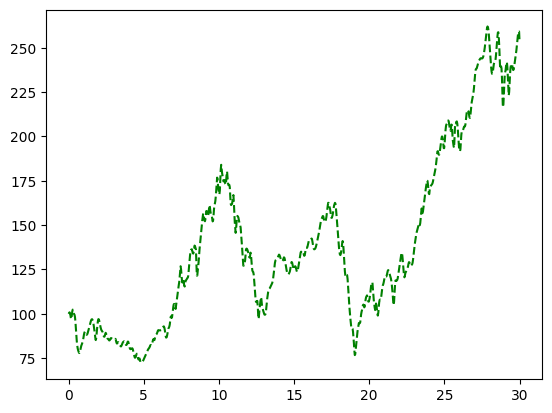

In [235]:
plt.plot(t, S_values, label='Money', color='green', linestyle='dashed')

In [36]:
g(10, 30)

np.float64(271.8281828459046)

In [20]:
#S_values[-1]
#d(t_span[-1])

np.float64(89392.92334885757)

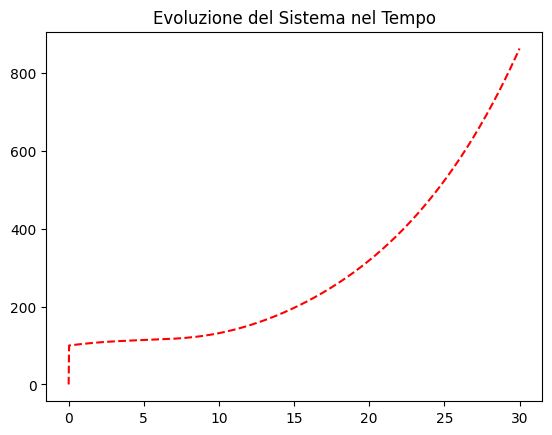

In [6]:


# Create secondary y-axis
#ax2 = ax1.twinx()
#plt.plot(t, [W(ti) for ti in t], label='Withdrawal', color='purple', linestyle='dashed')
plt.plot(t, [av_W(ti) for ti in t], label='Average Withdrawal Value', color='red', linestyle='dashed')
#plt.plot(t, S_values, label='Money', color='green', linestyle='dashed')
#plt.set_ylabel('Money')
#plt.legend(loc='upper right')

#ax2.plot(t, [g(0, ti) for ti in t])

# Title
plt.title('Evoluzione del Sistema nel Tempo')

plt.show()